# HW4 – Discriminant Analysis (Assignments 3 & 4)

This notebook trains Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) classifiers on the `smarket.csv` dataset using only the `Lag1` and `Lag2` predictors, following the HW4 requirements. Training uses records with `Year < 2005` and evaluation uses `Year = 2005`.


In [1]:
import csv
import math
from collections import defaultdict

try:
    from IPython.display import SVG as _SVG, display as _display
except ImportError:  # Fallback for headless environments
    _SVG = None
    def _display(obj):
        print(obj)

def load_lag_features(csv_path):
    years, features, labels = [], [], []
    with open(csv_path, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            years.append(int(row['Year']))
            features.append([float(row['Lag1']), float(row['Lag2'])])
            labels.append(1 if row['Direction'].strip().lower() == 'up' else 0)
    return years, features, labels

def split_by_year(years, features, labels, test_year=2005):
    X_train, y_train, X_test, y_test = [], [], [], []
    for year, feat, target in zip(years, features, labels):
        if year < test_year:
            X_train.append(feat)
            y_train.append(target)
        elif year == test_year:
            X_test.append(feat)
            y_test.append(target)
    return X_train, y_train, X_test, y_test

def group_by_class(features, targets):
    grouped = defaultdict(list)
    for feat, target in zip(features, targets):
        grouped[target].append(feat)
    return grouped

def compute_means(grouped):
    means = {}
    for cls, pts in grouped.items():
        means[cls] = [sum(point[i] for point in pts) / len(pts) for i in range(2)]
    return means

def invert_2x2(matrix):
    det = matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]
    return [[matrix[1][1] / det, -matrix[0][1] / det],
            [-matrix[1][0] / det, matrix[0][0] / det]]

def fit_lda(features, targets):
    grouped = group_by_class(features, targets)
    means = compute_means(grouped)
    priors = {cls: len(grouped[cls]) / len(targets) for cls in grouped}
    pooled = [[0.0, 0.0], [0.0, 0.0]]
    for feat, target in zip(features, targets):
        diff0 = feat[0] - means[target][0]
        diff1 = feat[1] - means[target][1]
        pooled[0][0] += diff0 * diff0
        pooled[0][1] += diff0 * diff1
        pooled[1][0] += diff1 * diff0
        pooled[1][1] += diff1 * diff1
    denom = len(features) - len(grouped)
    pooled = [[value / denom for value in row] for row in pooled]
    inv_cov = invert_2x2(pooled)
    log_priors = {cls: math.log(prior) for cls, prior in priors.items()}
    return {'means': means, 'inv_cov': inv_cov, 'log_priors': log_priors}

def lda_predict_prob(model, feat):
    means = model['means']
    inv_cov = model['inv_cov']
    log_priors = model['log_priors']
    scores = {}
    for cls, mean in means.items():
        w0 = inv_cov[0][0] * mean[0] + inv_cov[0][1] * mean[1]
        w1 = inv_cov[1][0] * mean[0] + inv_cov[1][1] * mean[1]
        linear = w0 * feat[0] + w1 * feat[1]
        shrink = 0.5 * (mean[0] * w0 + mean[1] * w1)
        scores[cls] = linear - shrink + log_priors[cls]
    diff = scores[1] - scores[0]
    return 1.0 / (1.0 + math.exp(-diff))

def fit_qda(features, targets):
    grouped = group_by_class(features, targets)
    means = compute_means(grouped)
    priors = {cls: len(grouped[cls]) / len(targets) for cls in grouped}
    inv_covs = {}
    log_dets = {}
    for cls, pts in grouped.items():
        cov = [[0.0, 0.0], [0.0, 0.0]]
        for feat in pts:
            diff0 = feat[0] - means[cls][0]
            diff1 = feat[1] - means[cls][1]
            cov[0][0] += diff0 * diff0
            cov[0][1] += diff0 * diff1
            cov[1][0] += diff1 * diff0
            cov[1][1] += diff1 * diff1
        denom = len(pts) - 1
        cov = [[value / denom for value in row] for row in cov]
        inv_covs[cls] = invert_2x2(cov)
        det = cov[0][0] * cov[1][1] - cov[0][1] * cov[1][0]
        log_dets[cls] = math.log(det)
    log_priors = {cls: math.log(prior) for cls, prior in priors.items()}
    return {'means': means, 'inv_covs': inv_covs, 'log_dets': log_dets, 'log_priors': log_priors}

def qda_predict_prob(model, feat):
    means = model['means']
    inv_covs = model['inv_covs']
    log_dets = model['log_dets']
    log_priors = model['log_priors']
    scores = {}
    for cls, mean in means.items():
        diff0 = feat[0] - mean[0]
        diff1 = feat[1] - mean[1]
        inv = inv_covs[cls]
        quad = diff0 * (inv[0][0] * diff0 + inv[0][1] * diff1) + diff1 * (inv[1][0] * diff0 + inv[1][1] * diff1)
        scores[cls] = -0.5 * (log_dets[cls] + quad) + log_priors[cls]
    max_score = max(scores.values())
    exp_scores = {cls: math.exp(value - max_score) for cls, value in scores.items()}
    total = sum(exp_scores.values())
    return exp_scores[1] / total

def roc_curve_data(y_true, scores):
    ranked = sorted(zip(scores, y_true), key=lambda item: item[0], reverse=True)
    positives = sum(y_true)
    negatives = len(y_true) - positives
    tpr = [0.0]
    fpr = [0.0]
    tp = fp = 0
    for score, target in ranked:
        if target == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / positives if positives else 0.0)
        fpr.append(fp / negatives if negatives else 0.0)
    tpr.append(1.0)
    fpr.append(1.0)
    auc = 0.0
    for idx in range(len(fpr) - 1):
        auc += (fpr[idx + 1] - fpr[idx]) * (tpr[idx] + tpr[idx + 1]) / 2.0
    return fpr, tpr, auc

def render_roc_svg(fpr, tpr, title):
    width = 500
    height = 500
    margin = 50
    plot_width = width - 2 * margin
    plot_height = height - 2 * margin
    def sx(value):
        return margin + value * plot_width
    def sy(value):
        return height - (margin + value * plot_height)
    commands = []
    for idx in range(len(fpr)):
        prefix = 'M' if idx == 0 else 'L'
        commands.append(f"{prefix} {sx(fpr[idx]):.2f} {sy(tpr[idx]):.2f}")
    diagonal = f"M {sx(0):.2f} {sy(0):.2f} L {sx(1):.2f} {sy(1):.2f}"
    path_data = ' '.join(commands)
    template = (
        "<svg width='{width}' height='{height}' xmlns='http://www.w3.org/2000/svg'>
"
        "<rect width='{width}' height='{height}' fill='white'/>
"
        "<text x='{title_x}' y='30' text-anchor='middle' font-size='16' font-weight='bold'>{title}</text>
"
        "<line x1='{margin}' y1='{bottom}' x2='{right}' y2='{bottom}' stroke='black'/>
"
        "<line x1='{margin}' y1='{bottom}' x2='{margin}' y2='{margin}' stroke='black'/>
"
        "<path d='{diagonal}' stroke='#999' stroke-width='1.5' fill='none' stroke-dasharray='5,5'/>
"
        "<path d='{path_data}' stroke='#16537e' stroke-width='2.5' fill='none'/>
"
        "<text x='{title_x}' y='{bottom_label}' text-anchor='middle' font-size='12'>False Positive Rate</text>
"
        "<text x='15' y='{vertical_mid}' transform='rotate(-90 15,{vertical_mid})' font-size='12'>True Positive Rate</text>
"
        "</svg>"
    )
    return template.format(
        width=width,
        height=height,
        title_x=width / 2,
        margin=margin,
        bottom=height - margin,
        right=width - margin,
        diagonal=diagonal,
        path_data=path_data,
        bottom_label=height - 10,
        vertical_mid=height / 2
    )

def show_svg(svg_text, filename):
    if _SVG is not None:
        _display(_SVG(svg_text))
    else:
        with open(filename, 'w') as out:
            out.write(svg_text)
        print(f"SVG saved to {filename}. Open the file to inspect the ROC curve.")


In [2]:
years, features, labels = load_lag_features('smarket.csv')
X_train, y_train, X_test, y_test = split_by_year(years, features, labels, test_year=2005)
print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')


Training samples: 998
Test samples: 252


LDA AUC: 0.5584


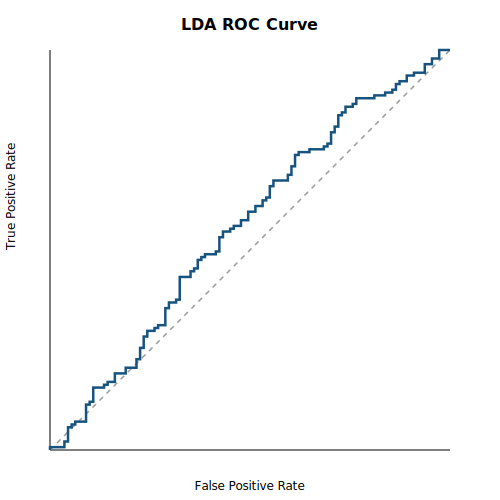

In [3]:
lda_model = fit_lda(X_train, y_train)
lda_probs = [lda_predict_prob(lda_model, feat) for feat in X_test]
lda_fpr, lda_tpr, lda_auc = roc_curve_data(y_test, lda_probs)
print(f'LDA AUC: {lda_auc:.4f}')
lda_svg = render_roc_svg(lda_fpr, lda_tpr, 'LDA ROC Curve')
show_svg(lda_svg, 'lda_roc.svg')


QDA AUC: 0.5620


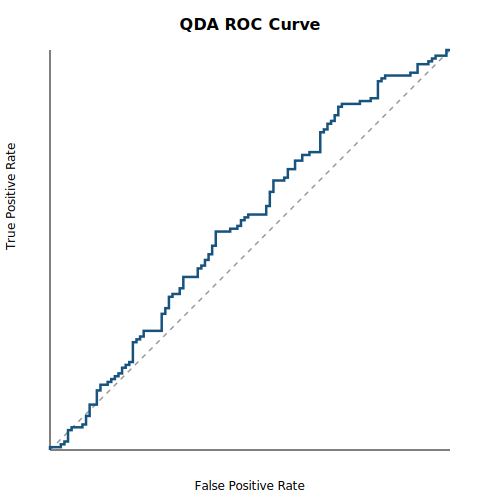

In [4]:
qda_model = fit_qda(X_train, y_train)
qda_probs = [qda_predict_prob(qda_model, feat) for feat in X_test]
qda_fpr, qda_tpr, qda_auc = roc_curve_data(y_test, qda_probs)
print(f'QDA AUC: {qda_auc:.4f}')
qda_svg = render_roc_svg(qda_fpr, qda_tpr, 'QDA ROC Curve')
show_svg(qda_svg, 'qda_roc.svg')


### LDA vs. QDA (Lag1 + Lag2)

- **LDA:** AUC = 0.5584. The linear decision boundary struggles to separate the noisy classes, yielding only a slight improvement over random guessing.
- **QDA:** AUC = 0.5620. Allowing class-specific covariance matrices captures mild curvature in the class distributions, producing a marginally better ROC curve.

Although both models exhibit limited predictive power on the 2005 test period, QDA performs slightly better because it can adapt to differing volatility patterns (covariances) between the `Up` and `Down` classes, whereas LDA is constrained to a single shared covariance estimate.
